In [1]:
import numpy as np
from load_data import load_data
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
from pyclustering.cluster.clique import clique, clique_visualizer

In [2]:
data = load_data('Data/20242025premierleague.csv')
ground_truth = encode_results(data['FTR'])
data = pd.get_dummies(data, columns=['HomeTeam', 'AwayTeam', 'Referee']) # One-Hot encode string features
print("Amount of home wins: ", np.sum(ground_truth == 1))
print("Amount of away wins: ", np.sum(ground_truth == -1))
print("Amount of draws: ", np.sum(ground_truth == 0))

Data loaded successfully from Data/20242025premierleague.csv
Amount of home wins:  155
Amount of away wins:  132
Amount of draws:  93


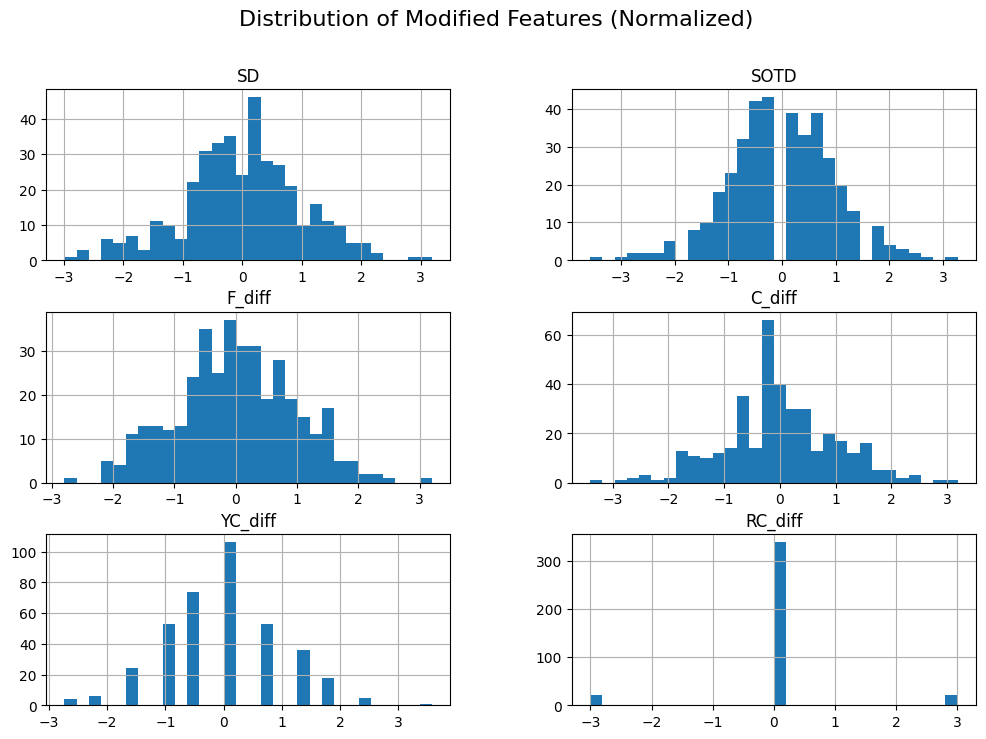

In [3]:
# --- Load in game statistics ---
raw_in_game_stats = data[[ 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']]

# --- Create new features by calculating the difference between home and away statistics (Positive Home team have more) ---
modified_stats = pd.DataFrame({'SD': data['HS'] - data['AS'],
                            'SOTD': data['HST'] - data['AST'],
                            'F_diff': data['HF'] - data['AF'],
                            'C_diff': data['HC'] - data['AC'],
                            'YC_diff': data['HY'] - data['AY'],
                            'RC_diff': data['HR'] - data['AR']
                            }) 

# --- Normalize the new features with average and standard deviation ---
modified_stats = (modified_stats - modified_stats.mean()) / modified_stats.std()

#print(modified_stats['SD'].mean(), modified_stats['SD'].std())

# -- Plot as histogram to see the distribution of the new features ---
modified_stats.hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribution of Modified Features (Normalized)', fontsize=16)
plt.show()

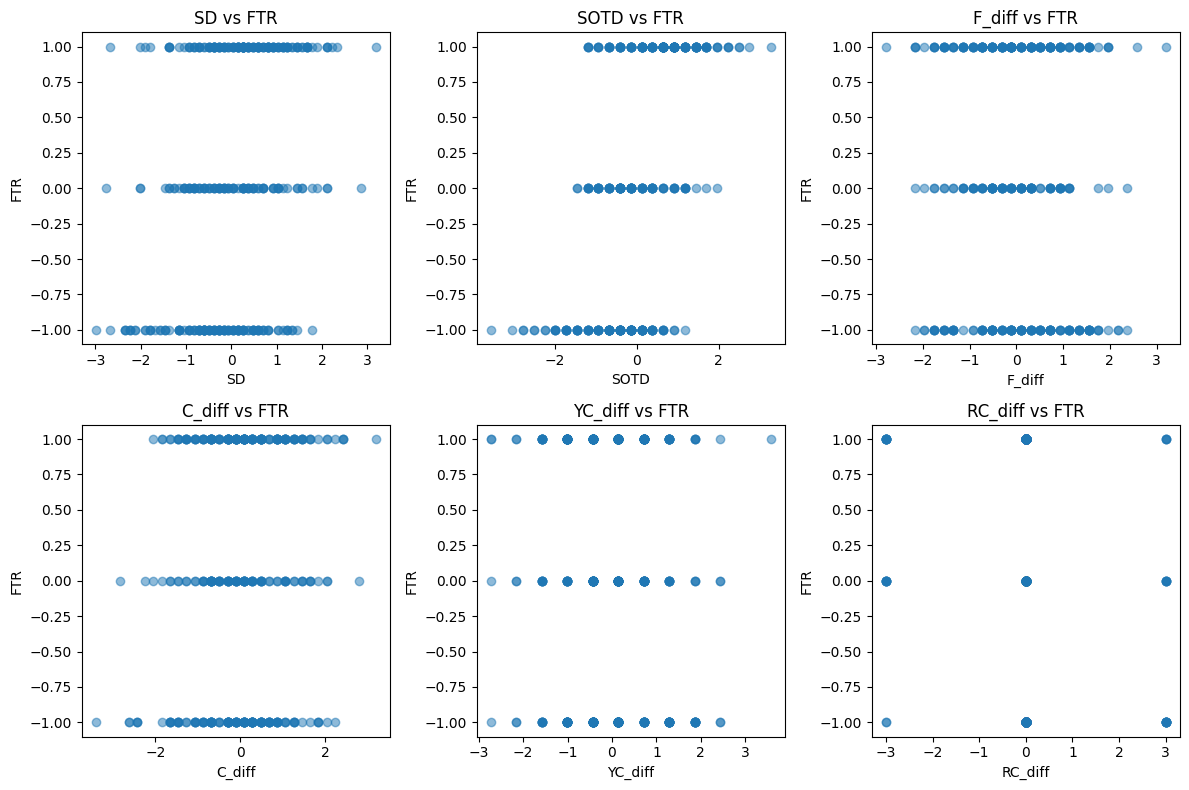

In [4]:
# --- Plotting the relationship between the new features and the target variable ---
plt.figure(figsize=(12, 8))
for i, column in enumerate(modified_stats.columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(modified_stats[column], ground_truth, alpha=0.5)
    plt.title(f'{column} vs FTR')
    plt.xlabel(column)
    plt.ylabel('FTR')
plt.tight_layout()

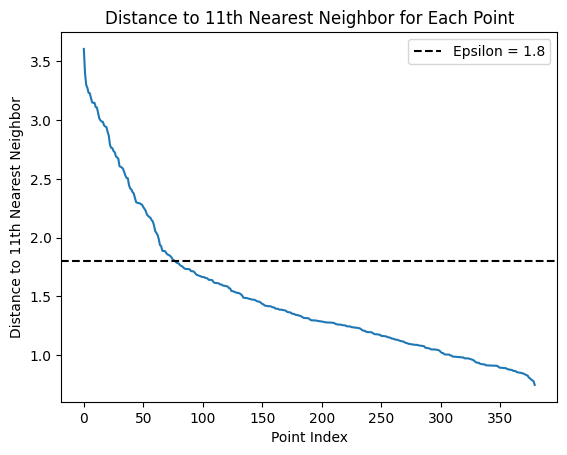

In [8]:
## ---  11th nearets neighbor distance since, default 2xd-1 as per slide 22

def find_k_nearest_neighbor_dist(data, minpts=None):
    """
    Args:
        data (numpy array): The input data.
        minpts (int): The number of the nearest neighbors to consider (default is 11).
    Returns:
        distance (numpy array): distance of 11th nearest neighbor sorted

    """
    n, d = data.shape
    if minpts is None:
        minpts = 2 * d - 1

    distances = np.zeros(n)
    for p in range(n):
        p_distances = np.zeros(n)
        for neighbor in range(n):
            p_distances[neighbor] = euc_distance(data[neighbor], data[p]) # Distance to neighbors
        p_distances = np.sort(p_distances)
        distances[p] = p_distances[minpts]    
    return np.sort(distances)[::-1], minpts # Return the sorted distance to the k-th nearest neighbor from heighest to lowest

# -- Plotting ---
y, minpts = find_k_nearest_neighbor_dist(modified_stats.values)
x = np.arange(len(y))
epsilon = 1.8
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Point Index")
ax.set_ylabel(f"Distance to {minpts}th Nearest Neighbor")
ax.set_title(f"Distance to {minpts}th Nearest Neighbor for Each Point")
ax.axhline(epsilon, c='k', ls='--', label=f'Epsilon = {epsilon}')
plt.legend()


## DBSCAN clustering

In [9]:
from sklearn.cluster import DBSCAN, OPTICS
# --- Use DBSCAN to find dense regions in the modified feature space ---
dbscan = DBSCAN(eps=epsilon, min_samples=minpts)
dbscan.fit(modified_stats.values)
labels = dbscan.labels_
print("DBSCAN Cluster Labels:", np.unique(labels)) # -1 corresponds to noise points, other integers correspond to cluster labels
# --- making a contengincy tabele to compare the cluster labels with the ground truth ---
c_table = contingency_table(labels, ground_truth)
print("Contingency Table:\n", c_table) 
# --- Calculate the purity of the clustering ---
purity = purity_score(c_table)
print(f"Purity score of the clustering: {purity}")

DBSCAN Cluster Labels: [-1  0]
Contingency Table:
 [[117  79 138]]
Purity score of the clustering: [0.41317365]


## K-Means++ clustering

In [10]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3).fit(modified_stats.values)
labels_kmeans = k_means.labels_
centroids = k_means.cluster_centers_
# --- making a contengincy tabele to compare the cluster labels with the ground truth ---
c_table = contingency_table(labels_kmeans, ground_truth)
print("Contingency Table:\n", c_table) 
# --- Calculate the purity of the clustering ---
purity = purity_score(c_table)
print(f"Purity score of the clustering: {purity}")


Contingency Table:
 [[32 26 73]
 [66 35 33]
 [34 32 49]]
Purity score of the clustering: [0.55725191 0.49253731 0.42608696]


## Where are we?

### TODO:
Implement subclustering algorithm to find optimal subspaces for clustering, maybe PROCLUS
Implement K-means++, since we know that we should have 3 clusters since thats our ground truth dimension

### What has suceeded so far:
- We have loaded our data 
- one hot encoded datatypes that were strings in original file
- Modified features to look at diffrences
- Normalized all features to make them more compareable
- Heuristics tuning: We tried to find an optimal $\epsilon$-parameter and minpts
- Used these parameters to do DBSCAN clustering
- Evaluated clusters by making a contingency table and a purity measure


### What is the problems we have encountered:
- It seems that the obtained clusters doesn't make much sense compared to our ground truth